In [2]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [3]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [30]:
import pprint
import glob
from pathlib import Path
import pickle

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [34]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, gt_shapes_dict, only_show_instances=[], num_novel_view=3):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    output_dir = "{}_{}".format(input_dir_mesh, exp_name)
    
    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(output_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                # loading trimesh and pytorch3d meshes for the g.t., originally reconstructed, and refined model
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                gt_mesh_path = gt_shapes_dict[instance_name]
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                    mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                
                # rendering gt, original, and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
                mesh_gt_render = utils.render_mesh(mesh_gt, R, T, device)
                mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
                mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)
                
                # rendering processed mesh at poses other than the predicted pose
                novel_view_renders = []
                for i in range(num_novel_view):
                    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim+ ((i+1)*45))
                    novel_view_renders.append(utils.render_mesh(mesh_processed, R, T, device))
                
                # computing performance metrics before refinement
                #iou_2d_before = compute_iou_2d(mesh_original, input_image, device)
                iou_2d_before = compute_iou_2d_given_pose(mesh_original, input_image, device, pred_azim, pred_elev, pred_dist)
                iou_3d_before = compute_iou_3d(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                chamfer_before = compute_chamfer_L1(mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt)
                # computing metrics after refinement
                #iou_2d_after = compute_iou_2d(mesh_processed, input_image, device)
                # TODO: not sure if using the original pred pose for the processed iou is legitimate
                iou_2d_after = compute_iou_2d_given_pose(mesh_processed, input_image, device, pred_azim, pred_elev, pred_dist)
                iou_3d_after = compute_iou_3d(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)
                chamfer_after = compute_chamfer_L1(mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt)

                # visualizing
                print(processed_mesh_path)
                print("Metrics before refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_before, iou_3d_before, chamfer_before))
                print("Metrics after refinement -- 2d IoU: {}, 3d IoU: {}, Chamfer dist: {}".format(iou_2d_after, iou_3d_after, chamfer_after))
                
                fig, ax = plt.subplots(nrows=1, ncols=4+num_novel_view, squeeze=False, figsize=(15,5))
                ax[0][0].imshow(input_image)
                ax[0][0].xaxis.set_visible(False)
                ax[0][0].yaxis.set_visible(False)
                
                ax[0][1].imshow(mesh_gt_render[0, ..., :3].cpu().numpy())
                ax[0][1].xaxis.set_visible(False)
                ax[0][1].yaxis.set_visible(False)      

                ax[0][2].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
                ax[0][2].xaxis.set_visible(False)
                ax[0][2].yaxis.set_visible(False)

                ax[0][3].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
                ax[0][3].xaxis.set_visible(False)
                ax[0][3].yaxis.set_visible(False)
                
                for i in range(num_novel_view):
                    ax[0][3+i+1].imshow(novel_view_renders[i][0, ..., :3].cpu().numpy())
                    ax[0][3+i+1].xaxis.set_visible(False)
                    ax[0][3+i+1].yaxis.set_visible(False)
                plt.pause(0.05)

In [17]:
cfg_path = "configs/testing.yaml"
exp_name = "processed"
gt_shapes_path = "/home/svcl-oowl/brandon/research/sil_consistent_at_inference/data_evaluation/pix3d_chair/pix3d_chair_gt_shapes.lst"

cfg = utils.load_config(cfg_path, "configs/default.yaml")
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]

data/test_dataset_processed/batch_1_of_5/0214.obj
Metrics before refinement -- 2d IoU: 0.5163965742303162, 3d IoU: 0.08065246790647507, Chamfer dist: 0.003017558017745614
Metrics after refinement -- 2d IoU: 0.8288811795316565, 3d IoU: 0.11932635307312012, Chamfer dist: 0.002644321881234646


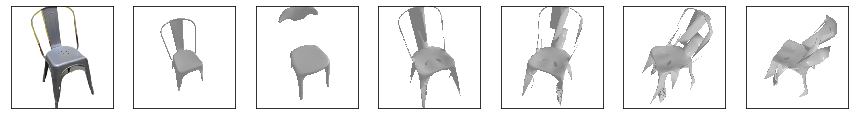

data/test_dataset_processed/batch_1_of_5/0015.obj
Metrics before refinement -- 2d IoU: 0.30379997622538335, 3d IoU: 0.2506803870201111, Chamfer dist: 0.001769153750501573
Metrics after refinement -- 2d IoU: 0.7820475266376186, 3d IoU: 0.12060821056365967, Chamfer dist: 0.0046784598380327225


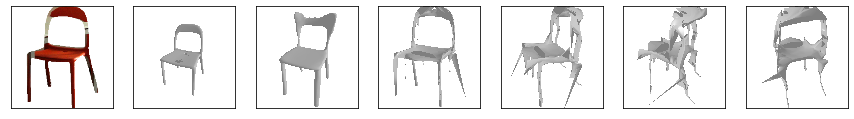

data/test_dataset_processed/batch_2_of_5/1445.obj
Metrics before refinement -- 2d IoU: 0.6971089801604653, 3d IoU: 0.08301067352294922, Chamfer dist: 0.033123601227998734
Metrics after refinement -- 2d IoU: 0.9296184956766975, 3d IoU: 0.03973018378019333, Chamfer dist: 0.025989506393671036


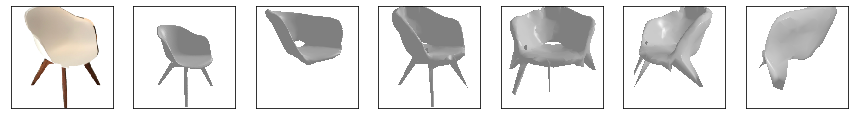

data/test_dataset_processed/batch_2_of_5/2795.obj
Metrics before refinement -- 2d IoU: 0.4873330534008118, 3d IoU: 0.08379828929901123, Chamfer dist: 0.014579486101865768
Metrics after refinement -- 2d IoU: 0.9359391792381483, 3d IoU: 0.08216679841279984, Chamfer dist: 0.014679677784442902


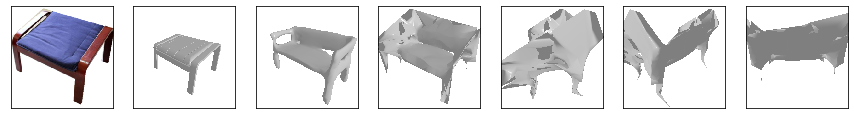

data/test_dataset_processed/batch_2_of_5/1819.obj
Metrics before refinement -- 2d IoU: 0.7198268107511664, 3d IoU: 0.7121506929397583, Chamfer dist: 0.007694825064390898
Metrics after refinement -- 2d IoU: 0.9676928415323832, 3d IoU: 0.6862828731536865, Chamfer dist: 0.012064697220921516


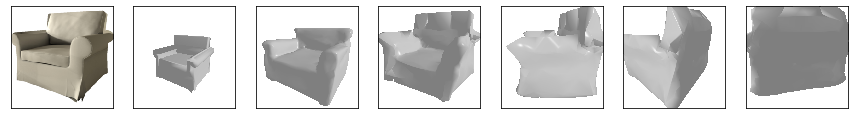

data/test_dataset_processed/batch_3_of_5/3704.obj
Metrics before refinement -- 2d IoU: 0.48542455650787325, 3d IoU: 0.012513842433691025, Chamfer dist: 0.004487747326493263
Metrics after refinement -- 2d IoU: 0.8499795193883124, 3d IoU: 0.016943834722042084, Chamfer dist: 0.003369370009750128


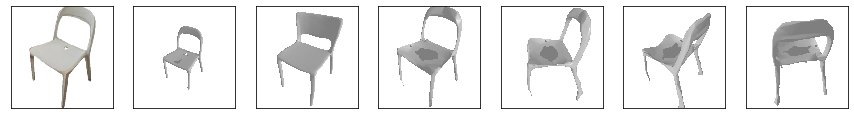

data/test_dataset_processed/batch_3_of_5/2804.obj
Metrics before refinement -- 2d IoU: 0.5061615278571668, 3d IoU: 0.18466083705425262, Chamfer dist: 0.021006977185606956
Metrics after refinement -- 2d IoU: 0.9207032586961612, 3d IoU: 0.17767447233200073, Chamfer dist: 0.016166452318429947


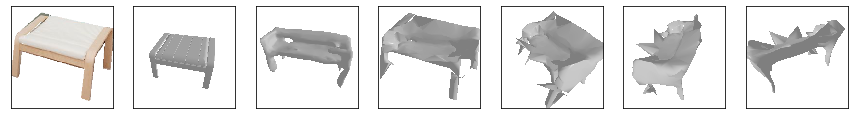

KeyError: 'f550b5413eb040c29829306a513f9466'

In [37]:
# show postprocessed meshes at predicted angle
#show_meshes(cfg, device, cfg['dataset']['input_dir_mesh']+"_{}".format(exp_name), gt_shapes_dict, only_show_instances=["0214"])
show_meshes(cfg, device, cfg['dataset']['input_dir_mesh']+"_{}".format(exp_name), gt_shapes_dict, only_show_instances=[])

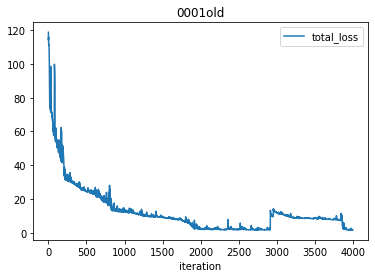

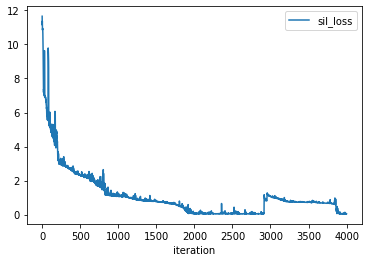

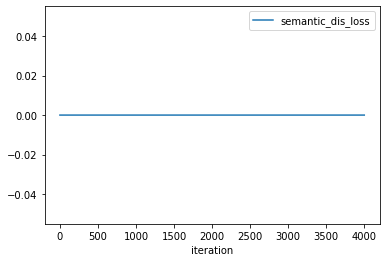

In [61]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        loss_info.plot.line(x='iteration', y='semantic_dis_loss')